In [33]:
import os
from osgeo import gdal
import rasterio
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
raster_file_base = '/data/nca/ancillary/IUCN/GET/all-maps-raster-geotiff'
raster_file = '/data/nca/ancillary/IUCN/GET/all-maps-raster-geotiff/T2_2_Deciduous_temperate_forests.tif'
stats_file_base = '/data/nca/test/Bruno/WEED'

In [35]:
#Czech Republic
zonal_file = '/data/nca/weed/CU_testSites/priorityareasCZ_4326_singleShape.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasCZ_GET.csv')

In [232]:
#Norway
zonal_file = '/data/nca/weed/CU_testSites/priorityareasNO_4326.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasNO_GET.csv')

In [244]:
#Greece
zonal_file = '/data/nca/weed/CU_testSites/priorityareasEL_4326.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasEL_GET.csv')

In [263]:
#Colombia
zonal_file = '/data/nca/weed/CU_testSites/priorityareasCO_4326.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasCO_GET.csv')

In [25]:
#South-Africa
zonal_file = '/data/nca/weed/CU_testSites/priorityareasSA_4326.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasSA_GET.csv')

In [3]:
#Vietnam
zonal_file = '/data/nca/weed/CU_testSites/priorityareasVN_4326.gpkg'
stats_summary_file =  os.path.join(stats_file_base,'priorityareasVN_GET.csv')

In [4]:
get_files = os.listdir(raster_file_base)
get_list=[]
for file in get_files:
    print(file)
    e = 4
    if not file.endswith('.tif'): continue
    if (file.startswith('FM')) or (file.startwith('MT')) or (file.startswith('SF')) or (file.startswith('SM')) or (file.startswith('TF')): e = 5
    if file.strtswith('MTF'): e = 6
    get_list.append(file[0:e])
        
#get_list = [x[0:4] for x in get_files if x.endswith('tif')]

F1_1_Perm_upland_streams.tif


AttributeError: 'str' object has no attribute 'startwith'

In [36]:
get_files = os.listdir(raster_file_base)
get_list = [x[0:6] for x in get_files if x.endswith('tif')]

In [37]:
file.startswith('FM') or file.startswith('MT')

False

In [38]:
df_zonal = gpd.read_file(zonal_file)
df_zonal

,NAZEV,geometry
0,Bílé Karpaty,"POLYGON ((17.885 49.157, 17.885 49.157, 17.885..."
1,Krkonošský národní park,"POLYGON ((15.45 50.807, 15.451 50.806, 15.451 ..."
2,Podyjí,"POLYGON ((15.865 48.916, 15.865 48.916, 15.865..."


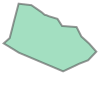

In [39]:
row.geometry

In [40]:
def zonal_statistics(row, raster_file):
    Vector = df_zonal[df_zonal.Name ==row.Name]
    with rasterio.open(raster_file) as src:
        #Vector=Vector.to_csr(src.crs)
        out_image, out_transform=mask(src,Vector.geometry, crop=True)
        values = np.unique(out_image[0])

    result = dict()
    for value in values:
        #if value == 0 : continue
        #print(str(value) + ' = ', end="")
        #print(np.count_nonzero(out_image == value))
        result[value] = (np.count_nonzero(out_image[0] == value))

    return result

In [31]:
#plt.imshow(out_image[0])

In [27]:
df2 = pd.DataFrame(columns=get_list)
for row in df_zonal.itertuples():
    print('processing ' + row.Name)
    df = pd.DataFrame(columns=range(0,2+1))  #none, most likely, less likely
    #Vector = df_zonal[df_zonal.NAZEV ==row.NAZEV]
    for file in get_files:
        if not file.endswith('.tif'): continue
        get_type = file[0:6]
        raster_file = os.path.join(raster_file_base, file)
        #result = zonal_statistics(df_zonal, getattr(row, 'Index'), raster_file)
        result = zonal_statistics(row, raster_file)
        df.loc[get_type] = result
    #print(df)
    stats_file = os.path.join(stats_file_base,row.WEED_site+'.csv')
    df.to_csv(stats_file)
    #keep only valid types per zone and put in summary table with 1 or 2 values per EFG
    if 0 in df.columns: df.drop(columns=0, inplace=True)
    df.dropna(axis=0, inplace=True, how = 'all')
    df3 = df
    s = df3.idxmax(axis=1)
    for idx, row2 in s.items():
        df2.loc[row.WEED_site,idx] = row2
df2.T.to_csv(stats_summary_file)

processing Cape Point
processing Grootbos
processing Jonkershoek


In [19]:
df2.T

,VN1,VN2,VN3
F1_1_P,2,2,NaN
F1_2_P,1,NaN,NaN
F1_3_F,NaN,NaN,NaN
F1_4_S,1,1,1
F1_5_S,NaN,2,NaN
...,...,...,...
TF1_3_,NaN,NaN,NaN
TF1_4_,1,NaN,1
TF1_5_,NaN,NaN,NaN
TF1_6_,NaN,NaN,NaN


In [30]:
df2.iloc[2].dropna().index

Index(['F1_1_P', 'F1_4_S', 'F1_6_E', 'F3_1_L', 'F3_2_C', 'F3_5_C', 'S1_1_A',
       'S1_2_E', 'SF1_1_', 'SF2_1_', 'T3_2_S', 'T7_3_P', 'T7_4_U', 'TF1_2_'],
      dtype='object')